In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
%matplotlib inline
import os
import glob
import pickle
import umap
import pandas as pd
import seaborn as sns
from keras.models import load_model
from ponyo import utils
from sklearn.decomposition import PCA

from plotnine import (
    ggplot,
    labs,
    geom_line,
    geom_point,
    geom_errorbar,
    aes,
    ggsave,
    theme_bw,
    theme,
    xlim,
    ylim,
    facet_wrap,
    scale_color_manual,
    guides,
    guide_legend,
    element_blank,
    element_text,
    element_rect,
    element_line,
    coords,
    options,
)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = "config_sophie_vs_trad.tsv"

params = utils.read_config(config_filename)

In [3]:
# Load config params

# Local directory to store intermediate files
local_dir = params["local_dir"]

# ID for template experiment to be selected
project_id = params["project_id"]

# File containing un-normalized template experiment
raw_template_filename = params["raw_template_filename"]

# Normalized compendium filename
normalized_compendium_filename = params["normalized_compendium_filename"]

# Directory containing trained VAE model
vae_model_dir = params["vae_model_dir"]

# Pickle files saving specific and generic gene ids
template_specific_gene_ids_filename = params["template_specific_gene_ids_filename"]
generic_gene_ids_filename = "generic_gene_ids.pickle"

# Identifier for simulated experiment
i = 7

# File to scaler transform data to 0-1 range
scaler_transform_filename = params["scaler_filename"]

## Check clustering

In [4]:
simulated_filename = os.path.join(
    local_dir,
    "pseudo_experiment",
    f"selected_simulated_data_{project_id}_{i}.txt",
)

In [5]:
simulated_experiment = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

In [6]:
print(simulated_experiment.shape)
simulated_experiment.head()

(8, 1000)


,G_0,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,...,G_990,G_991,G_992,G_993,G_994,G_995,G_996,G_997,G_998,G_999
0_control,92.580,164.396,156.141,161.188,33.549,148.644,110.839,163.432,324.771,105.224,...,118.184,130.439,123.166,137.003,269.723,160.960,98.303,75.276,80.993,108.906
1_control,82.473,150.121,165.383,129.461,35.421,128.562,114.754,167.509,274.347,120.777,...,124.518,122.635,122.073,136.003,220.463,133.058,105.986,77.217,99.476,91.928
2_control,90.821,179.538,150.304,159.131,37.901,181.750,98.429,151.236,295.819,114.022,...,155.291,144.221,109.665,168.808,247.144,158.836,95.710,85.234,97.066,90.330
3_control,100.489,185.080,174.306,161.411,40.587,198.741,120.419,173.415,339.429,127.849,...,133.531,152.761,120.019,148.805,265.722,175.810,105.049,80.920,92.558,123.315
4_perturb,107.831,161.974,182.163,150.223,90.346,343.376,74.917,178.984,369.642,76.971,...,103.767,157.888,116.615,85.165,287.454,183.480,116.672,64.876,69.438,125.943


In [7]:
# Get common genes
# Get specific genes

# Load pickled file
with open(template_specific_gene_ids_filename, "rb") as specific_fh:
    specific_gene_ids = pickle.load(specific_fh)

with open(generic_gene_ids_filename, "rb") as generic_fh:
    generic_gene_ids = pickle.load(generic_fh)

In [8]:
# Get NA genes
all_gene_ids = simulated_experiment.columns
all_gene_ids_tmp = all_gene_ids.difference(specific_gene_ids)
na_gene_ids = all_gene_ids_tmp.difference(generic_gene_ids)

In [9]:
# Simulated data subsets
simulated_specific_df = simulated_experiment[specific_gene_ids]
simulated_common_df = simulated_experiment[generic_gene_ids]
simulated_na_df = simulated_experiment[na_gene_ids]

In [10]:
print(simulated_specific_df.shape)
simulated_specific_df

(8, 10)


,G_622,G_809,G_158,G_156,G_726,G_322,G_910,G_691,G_86,G_321
0_control,117.478,58.143,191.432,71.435,85.023,108.306,182.339,309.811,349.869,1495.796
1_control,94.308,67.709,188.533,71.739,103.432,92.928,137.211,290.367,294.119,959.364
2_control,97.580,55.346,193.194,78.708,108.774,122.352,162.402,339.355,321.193,1413.720
3_control,119.570,71.695,206.641,76.148,93.814,113.339,177.256,324.214,318.087,1375.854
4_perturb,97.152,131.570,148.596,86.835,46.244,99.035,147.257,308.132,361.369,1194.126
5_perturb,110.182,145.722,211.274,82.062,58.511,116.540,172.321,347.629,388.376,1582.257
6_perturb,100.173,140.172,198.613,74.499,53.310,102.393,152.332,338.842,360.299,1294.546
7_perturb,97.419,122.647,168.487,76.843,44.803,95.149,133.210,321.636,338.357,1089.632


In [11]:
print(simulated_common_df.shape)
simulated_common_df

(8, 100)


,G_101,G_723,G_668,G_883,G_802,G_302,G_838,G_387,G_335,G_942,...,G_868,G_764,G_885,G_143,G_308,G_32,G_162,G_12,G_531,G_395
0_control,782.165,874.091,702.550,479.377,1329.987,563.846,696.277,955.264,588.971,956.724,...,755.742,677.925,654.986,790.297,826.665,1552.335,427.773,1338.667,933.482,690.611
1_control,708.206,866.457,685.622,467.404,1501.589,518.372,670.204,871.294,514.851,920.416,...,712.859,614.017,515.284,725.210,775.465,1498.059,392.325,1083.253,868.187,686.312
2_control,732.783,855.175,690.289,485.226,1320.370,520.542,682.478,876.903,559.658,974.812,...,744.268,610.605,586.266,748.126,836.437,1462.561,414.046,1174.266,989.145,701.125
3_control,769.371,897.162,725.510,506.408,1503.273,600.013,706.776,978.431,585.021,927.577,...,770.983,706.814,622.968,819.516,885.923,1649.621,440.624,1421.432,946.160,701.655
4_perturb,2218.690,2321.356,2368.076,2138.011,6441.197,2238.603,2287.209,3153.959,2270.098,2207.278,...,2473.769,2611.960,3791.626,2537.420,2545.670,3314.506,2155.891,5786.133,3047.927,2360.369
5_perturb,2189.925,2248.845,2344.390,2117.176,5888.834,2200.938,2235.143,3055.853,2232.659,2181.786,...,2405.158,2624.342,3679.481,2470.526,2565.036,3187.563,2091.588,5720.310,2989.047,2296.454
6_perturb,2239.306,2287.485,2351.566,2148.810,6230.188,2221.673,2274.774,3164.930,2261.555,2193.578,...,2453.669,2621.172,3695.139,2521.027,2570.160,3286.834,2131.044,5652.911,3082.262,2320.995
7_perturb,2245.674,2303.786,2385.416,2136.525,6517.713,2222.686,2275.542,3211.578,2250.991,2196.738,...,2467.164,2639.670,3802.662,2506.186,2575.880,3278.058,2151.489,5811.115,3077.270,2322.393


In [12]:
print(simulated_na_df.shape)
simulated_na_df

(8, 890)


,G_0,G_1,G_10,G_100,G_102,G_103,G_104,G_105,G_106,G_107,...,G_990,G_991,G_992,G_993,G_994,G_995,G_996,G_997,G_998,G_999
0_control,92.580,164.396,134.200,62.758,84.393,192.623,75.148,59.785,126.485,74.819,...,118.184,130.439,123.166,137.003,269.723,160.960,98.303,75.276,80.993,108.906
1_control,82.473,150.121,106.654,70.703,66.075,155.642,92.867,69.188,104.716,76.453,...,124.518,122.635,122.073,136.003,220.463,133.058,105.986,77.217,99.476,91.928
2_control,90.821,179.538,122.939,76.616,73.498,191.320,90.029,60.746,127.732,76.718,...,155.291,144.221,109.665,168.808,247.144,158.836,95.710,85.234,97.066,90.330
3_control,100.489,185.080,115.658,71.886,98.779,187.558,87.589,66.149,119.370,81.553,...,133.531,152.761,120.019,148.805,265.722,175.810,105.049,80.920,92.558,123.315
4_perturb,107.831,161.974,172.714,81.633,91.712,184.824,72.537,49.328,132.255,76.306,...,103.767,157.888,116.615,85.165,287.454,183.480,116.672,64.876,69.438,125.943
5_perturb,122.667,178.101,197.825,99.146,106.165,197.484,71.257,50.864,130.443,76.987,...,115.430,193.031,115.727,91.010,304.558,207.027,121.915,75.242,76.029,134.833
6_perturb,101.063,165.679,182.372,87.907,89.801,181.928,71.026,48.152,122.500,70.446,...,101.651,149.713,114.581,83.625,281.813,185.765,116.242,68.402,65.740,108.068
7_perturb,96.846,159.103,172.310,79.410,84.818,185.619,69.796,46.393,133.727,70.070,...,99.387,131.485,112.057,83.960,267.818,185.484,104.970,63.996,61.919,101.037


Text(0.5, 0.98, 'Simulated experiment specific genes')

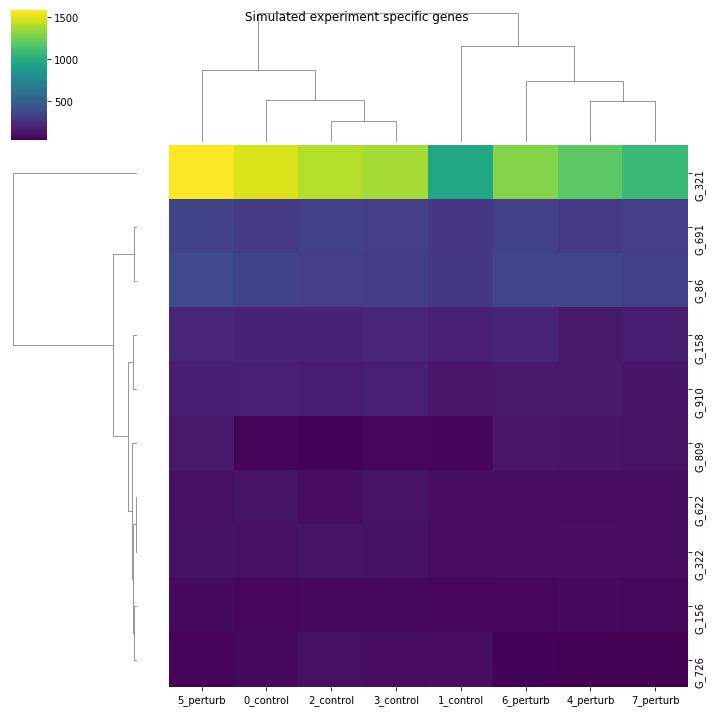

In [13]:
f = sns.clustermap(simulated_specific_df.T, cmap="viridis")
f.fig.suptitle("Simulated experiment specific genes")

Text(0.5, 0.98, 'Simulated experiment common genes')

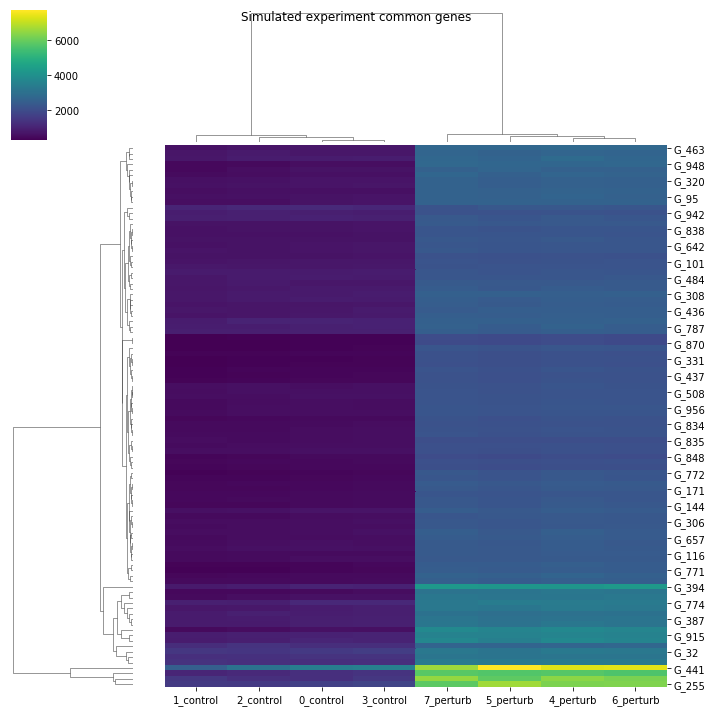

In [14]:
f = sns.clustermap(simulated_common_df.T, cmap="viridis")
f.fig.suptitle("Simulated experiment common genes")

Text(0.5, 0.98, 'Simulated experiment NA genes')

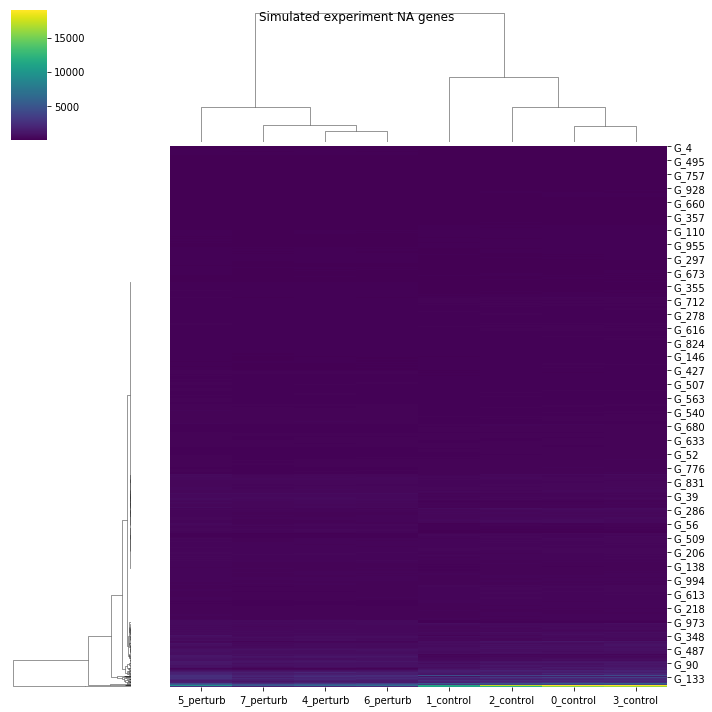

In [15]:
f = sns.clustermap(simulated_na_df.T, cmap="viridis")
f.fig.suptitle("Simulated experiment NA genes")

## Check latent space distribution

In [16]:
normalized_compendium = pd.read_csv(
    normalized_compendium_filename, sep="\t", index_col=0, header=0
)

In [17]:
# Files
model_encoder_filename = glob.glob(os.path.join(vae_model_dir, "*_encoder_model.h5"))[0]

weights_encoder_filename = glob.glob(
    os.path.join(vae_model_dir, "*_encoder_weights.h5")
)[0]

model_decoder_filename = glob.glob(os.path.join(vae_model_dir, "*_decoder_model.h5"))[0]

weights_decoder_filename = glob.glob(
    os.path.join(vae_model_dir, "*_decoder_weights.h5")
)[0]

# Load saved models
loaded_model = load_model(model_encoder_filename)
loaded_decode_model = load_model(model_decoder_filename)

loaded_model.load_weights(weights_encoder_filename)
loaded_decode_model.load_weights(weights_decoder_filename)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [18]:
# Encode normalized expression data
compendium_encoded = loaded_model.predict_on_batch(normalized_compendium)
compendium_encoded_df = pd.DataFrame(
    compendium_encoded, index=normalized_compendium.index
)

In [19]:
# PCA embedding of VAE encoded data

random_state = 1
pca = PCA(n_components=2)
model = pca.fit(compendium_encoded_df)

compendium_data_PCencoded = model.transform(compendium_encoded_df)
compendium_data_PCencoded_df = pd.DataFrame(
    data=compendium_data_PCencoded,
    index=compendium_encoded_df.index,
    columns=["1", "2"],
)

print(compendium_data_PCencoded_df.shape)
compendium_data_PCencoded_df.head()

(720, 2)


,1,2
0,-3.812715,8.608090
1,-3.771774,9.038836
2,-3.973315,7.247644
3,-3.824888,7.703296
4,-2.491874,9.481920


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


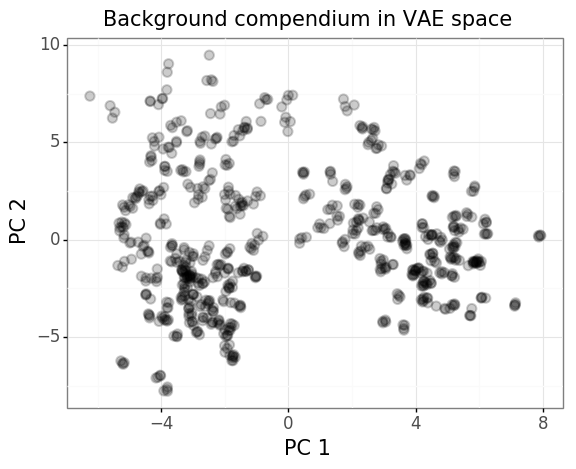

<ggplot: (8767114698658)>


In [20]:
# Plot
fig1 = ggplot(compendium_data_PCencoded_df, aes(x="1", y="2"))
fig1 += geom_point(alpha=0.2, size=3, stroke=0.8)
fig1 += labs(x="PC 1", y="PC 2", title="Background compendium in VAE space")
fig1 += theme_bw()
fig1 += theme(
    legend_title_align="center",
    plot_background=element_rect(fill="white"),
    legend_key=element_rect(fill="white", colour="white"),
    legend_title=element_text(family="sans-serif", size=15),
    legend_text=element_text(family="sans-serif", size=12),
    plot_title=element_text(family="sans-serif", size=15),
    axis_text=element_text(family="sans-serif", size=12),
    axis_title=element_text(family="sans-serif", size=15),
)
fig1 += guides(colour=guide_legend(override_aes={"alpha": 1}))

print(fig1)

What does the template compendium look like in the encoded latent space? Perhaps the encoder is compressing the difference in the perturbed and control samples too much.

If that is the case, then trying to increase the variance between the compendium experiments might help reduce the compression in the latent space.

In [21]:
# File storing normalized template experiment
normalized_template_filename = params["normalized_template_filename"]

normalized_template = pd.read_csv(
    normalized_template_filename, sep="\t", index_col=0, header=0
)

In [22]:
normalized_template.head()

,G_0,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,...,G_990,G_991,G_992,G_993,G_994,G_995,G_996,G_997,G_998,G_999
0_control,0.114003,0.116113,0.001288,0.000340,0.000000,0.002734,0.058944,0.000000,0.658839,0.020941,...,0.000264,0.000665,0.031963,0.000000,0.002248,0.014075,0.101308,0.014467,0.001393,0.002393
1_control,0.073833,0.106016,0.001288,0.000340,0.001048,0.002133,0.087775,0.000126,0.617321,0.026740,...,0.000352,0.000416,0.014460,0.000000,0.000999,0.019571,0.125244,0.017722,0.001203,0.001197
2_control,0.072984,0.063105,0.001288,0.000681,0.001048,0.001531,0.060866,0.000126,0.567161,0.054124,...,0.000088,0.000665,0.012177,0.000000,0.001249,0.012735,0.079599,0.010850,0.001647,0.002074
3_control,0.072419,0.082036,0.001546,0.000340,0.001572,0.001641,0.075602,0.000000,0.719519,0.043814,...,0.000264,0.000665,0.016743,0.000286,0.002123,0.020509,0.111049,0.015913,0.000570,0.001276
4_perturb,0.038755,0.063946,0.002061,0.000000,0.000000,0.000766,0.070477,0.000126,0.512869,0.039304,...,0.000088,0.000832,0.011416,0.000572,0.001998,0.020241,0.093515,0.011935,0.002027,0.001835


In [23]:
# Encode template experiment into VAE space
template_data_encoded = loaded_model.predict_on_batch(normalized_template)
template_data_encoded_df = pd.DataFrame(
    template_data_encoded, index=normalized_template.index
)

In [24]:
simulated_encoded_filename = os.path.join(
    local_dir,
    "pseudo_experiment",
    f"selected_simulated_encoded_data_{project_id}_{i}.txt",
)

simulated_data_encoded_df = pd.read_csv(
    simulated_encoded_filename, sep="\t", index_col=0, header=0
)

In [25]:
# Encode into PC space
template_data_PCencoded = model.transform(template_data_encoded_df)
template_data_PCencoded_df = pd.DataFrame(
    data=template_data_PCencoded,
    index=template_data_encoded_df.index,
    columns=["1", "2"],
)

print(template_data_PCencoded_df.shape)
template_data_PCencoded_df.head(10)

(8, 2)


,1,2
0_control,-3.010688,0.468929
1_control,-2.934546,0.663842
2_control,-2.872174,0.844467
3_control,-2.769404,0.882401
4_perturb,3.498765,1.749877
5_perturb,3.552898,2.209855
6_perturb,3.436776,2.108481
7_perturb,3.586740,1.780413


In [26]:
# Encode into PC space
simulated_data_PCencoded = model.transform(simulated_data_encoded_df)
simulated_data_PCencoded_df = pd.DataFrame(
    data=simulated_data_PCencoded,
    index=simulated_data_encoded_df.index,
    columns=["1", "2"],
)

print(simulated_data_PCencoded_df.shape)
simulated_data_PCencoded_df.head(10)

(8, 2)


,1,2
0_control,-1.672085,-3.021712
1_control,-1.595988,-2.826139
2_control,-1.533504,-2.645792
3_control,-1.430994,-2.608159
4_perturb,4.837492,-1.740768
5_perturb,4.891347,-1.280622
6_perturb,4.775049,-1.381578
7_perturb,4.925366,-1.709887


In [27]:
# Add labels
compendium_data_PCencoded_df["label"] = "compendium background"
template_data_PCencoded_df.loc[
    normalized_template.index.str.contains("perturb"), "label"
] = "template perturb samples"
template_data_PCencoded_df.loc[
    normalized_template.index.str.contains("control"), "label"
] = "template control samples"

simulated_data_PCencoded_df.loc[
    simulated_experiment.index.str.contains("perturb"), "label"
] = "simulated perturb samples"
simulated_data_PCencoded_df.loc[
    simulated_experiment.index.str.contains("control"), "label"
] = "simulated control samples"

In [28]:
all_data_PCencoded_df = pd.concat(
    [
        compendium_data_PCencoded_df,
        template_data_PCencoded_df,
        simulated_data_PCencoded_df,
    ]
)

print(all_data_PCencoded_df.shape)
all_data_PCencoded_df.head(20)

(736, 3)


,1,2,label
0,-3.812715,8.608090,compendium background
1,-3.771774,9.038836,compendium background
2,-3.973315,7.247644,compendium background
3,-3.824888,7.703296,compendium background
4,-2.491874,9.481920,compendium background
5,-2.568774,8.181230,compendium background
6,-2.425048,8.214870,compendium background
7,-2.376761,8.136181,compendium background
8,-4.150159,-2.155408,compendium background
9,-4.163589,-2.006777,compendium background


In [29]:
# Colors
marker_colors = {
    "template perturb samples": "red",
    "template control samples": "blue",
    "simulated perturb samples": "magenta",
    "simulated control samples": "cyan",
    "compendium background": "grey",
}

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


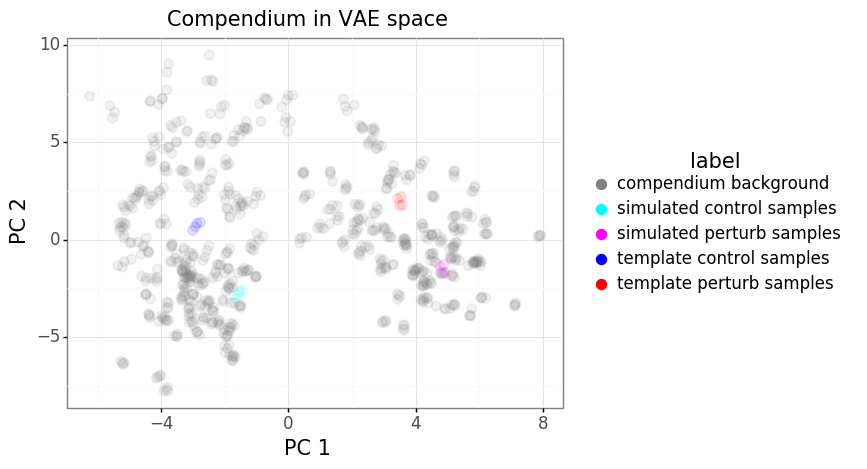

<ggplot: (8767098059405)>


In [30]:
# Plot
fig2 = ggplot(all_data_PCencoded_df, aes(x="1", y="2"))
fig2 += geom_point(aes(color="label"), alpha=0.1, size=3, stroke=0.8)
fig2 += scale_color_manual(values=marker_colors)
fig2 += labs(x="PC 1", y="PC 2", title="Compendium in VAE space")
fig2 += theme_bw()
fig2 += theme(
    # figure_size=(6, 10),
    legend_title_align="center",
    plot_background=element_rect(fill="white"),
    legend_key=element_rect(fill="white", colour="white"),
    legend_title=element_text(family="sans-serif", size=15),
    legend_text=element_text(family="sans-serif", size=12),
    plot_title=element_text(family="sans-serif", size=15),
    axis_text=element_text(family="sans-serif", size=12),
    axis_title=element_text(family="sans-serif", size=15),
)
fig2 += guides(colour=guide_legend(override_aes={"alpha": 1}))

print(fig2)